# Interpolating Results to Uniform Grid

In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.animation
import matplotlib.patches
import astropy.units as u
import astropy.constants as const
import numpy as np
from scipy.interpolate import interp1d,griddata,splev,splrep
from hydrad_tools.configure import Configure
from hydrad_tools.parse import Strand
from hydrad_tools.visualize import plot_strand, animate_strand
from IPython.display import HTML

%matplotlib inline

In [2]:
s = Strand('test_hydrad_run_eq_terms/',read_amr=False)

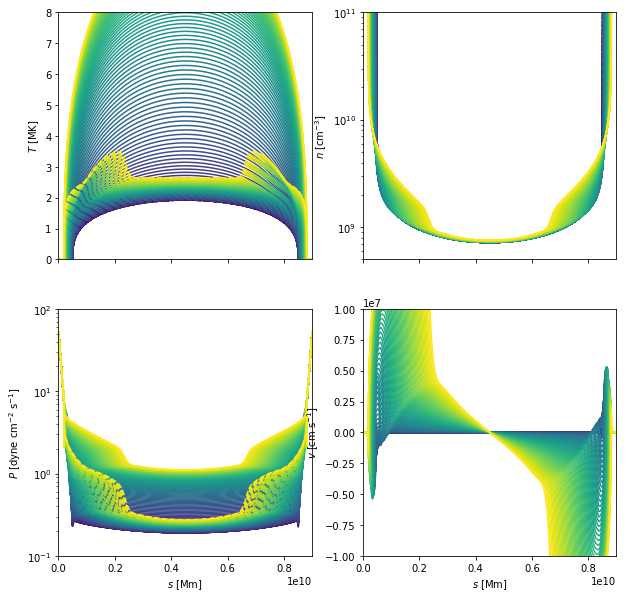

In [3]:
plot_strand(s,start=0,stop=1000,step=10,limits={'temperature':(0,8), 'density':(5e8,1e11),'velocity':(-1e7,1e7)})

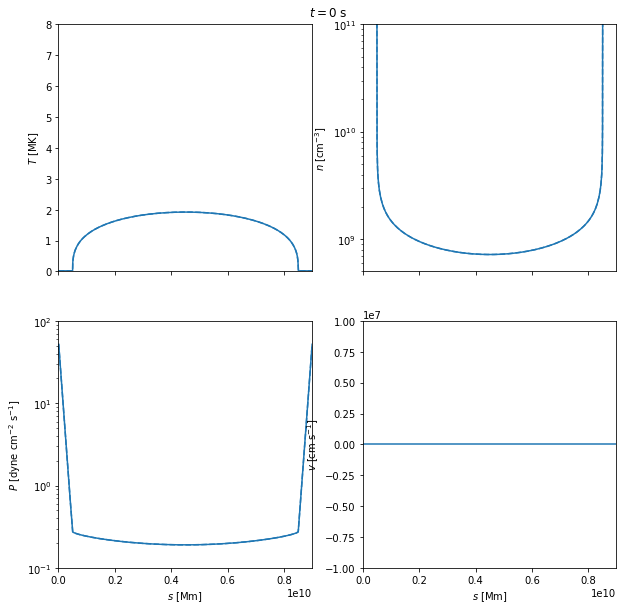

In [6]:
anim = animate_strand(s,start=0,stop=3000,step=10,limits={'temperature':(0,8), 'density':(5e8,1e11),'velocity':(-1e7,1e7)},interval=30)

In [7]:
HTML(anim.to_html5_video())

In [66]:
with open(os.path.join(s.hydrad_root,'Results','profile1000.amr')) as f:
    lines = f.readlines()
    grid_centers = np.zeros((int(lines[3]),))
    grid_widths = np.zeros((int(lines[3]),))
    for i,l in enumerate(lines[4:]):
        tmp = np.array(l.split(),dtype=float)
        grid_centers[i] = tmp[0]
        grid_widths[i] = tmp[1]

In [67]:
grid_edges = grid_centers - grid_widths/2.

In [20]:
ds_uniform = 5*u.Mm#(0.6*u.arcsec).to(u.radian).value * const.au.to(u.cm)

In [21]:
n_uniform = int(np.round((s.loop_length / ds_uniform).decompose()))

In [31]:
ds_hist,_ = np.histogram(grid_centers, bins=n_uniform, range=(0,s.loop_length.to(u.cm).value),
                         weights=grid_widths)
ds_quant,s_edges = np.histogram(grid_centers, bins=n_uniform, range=(0,s.loop_length.to(u.cm).value),
                          weights=grid_widths*s[10].velocity)
s_resampled = (s_edges[1:] + s_edges[:-1])/2.

In [32]:
s_resampled_interp = np.linspace(0,s.loop_length.to(u.cm).value,n_uniform)

In [33]:
#%%timeit
f_interp = interp1d(s[10].coordinate.to(u.cm).value, s[10].velocity.value,
                    kind='cubic',fill_value='extrapolate')
T_interp = f_interp(s_resampled_interp)

In [30]:
(5000 * 0.385)/3600

0.5347222222222222

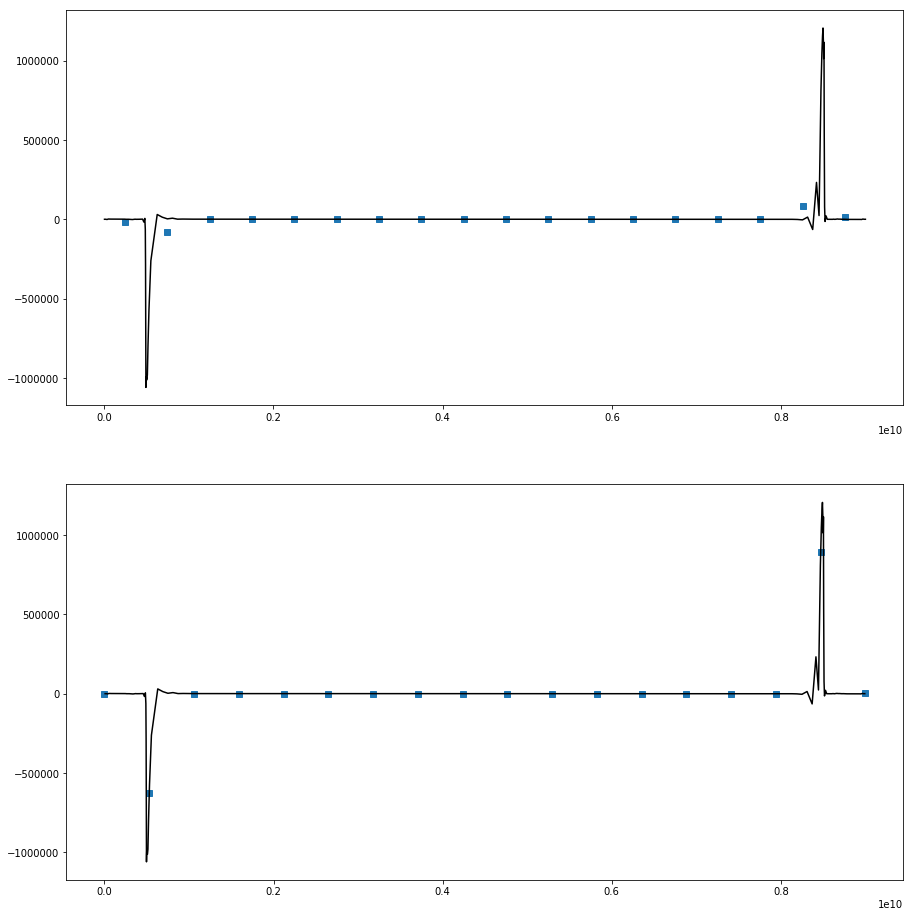

In [35]:
plt.figure(figsize=(15,16))
plt.subplot(211)
plt.plot(s_resampled,ds_quant/ds_hist,'s',color='C0')
plt.plot(s[10].coordinate,s[10].velocity,'-',color='k')
#plt.yscale('log')
plt.subplot(212)
plt.plot(s_resampled_interp, T_interp,'s',color='C0')
plt.plot(s[10].coordinate,s[10].velocity,'-',color='k')
#plt.yscale('log')

In [68]:
Te_resampled = ds_quant / ds_hist

/Users/willbarnes/anaconda/envs/hydrad_tools/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


## Visualizing grids

In [68]:
grid_edges_norm = grid_edges / s.loop_length.value
grid_widths_norm = grid_widths / s.loop_length.value

In [69]:
height = 0.5

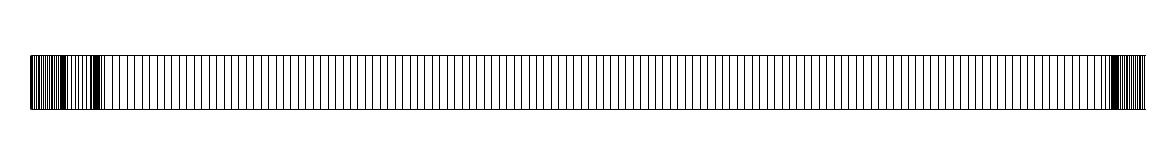

In [70]:
fig = plt.figure(figsize=(20,2))
ax = fig.gca()
ax.set_axis_off()
draw_kwargs = {'fill': False, 'lw': 1., 'edgecolor': 'k', 'facecolor': None}
for ge,gw in zip(grid_edges_norm,grid_edges_norm):
    rect = matplotlib.patches.Rectangle((ge,0.1),gw,height,**draw_kwargs)
    ax.add_patch(rect)
#plt.savefig('foo.pdf',)

(-1, 1)

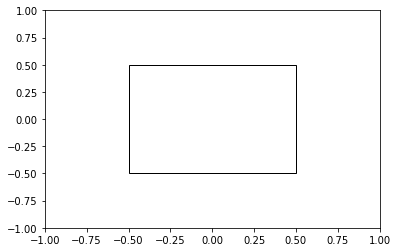

In [55]:
fig = plt.figure()
ax = fig.gca()
ax.add_patch(matplotlib.patches.Rectangle((-.5,-.5),1,1,**draw_kwargs),)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

In [73]:
foo = np.linspace(0,1,100000)*u.K
bar = np.random.rand(100000)*u.cm
np.average(foo, weights=bar)

<Quantity 0.50005013 K>

## 2D Interpolation
First, get all the coordinates, times, and values in one array

In [11]:
delta_s_hic = (((0.1*u.arcsec).to(u.radian).value * (const.au - const.R_sun)).to(u.cm)).value
uniform_s = np.arange(0,s.loop_length.to(u.cm).value,delta_s_hic)

In [12]:
Te_uniform = np.zeros(uniform_s.shape+s.time.shape)
n_uniform = np.zeros(uniform_s.shape+s.time.shape)
v_uniform = np.zeros(uniform_s.shape+s.time.shape)
for i,t in enumerate(s.time):
    p = s[i]
    knots = splrep(p.coordinate.value, p.electron_temperature.value, )
    Te_uniform[:,i] = splev(uniform_s,knots,ext=0)
    knots = splrep(p.coordinate.value, p.electron_density.value, )
    n_uniform[:,i] = splev(uniform_s,knots,ext=0)
    knots = splrep(p.coordinate.value, p.velocity.value, )
    v_uniform[:,i] = splev(uniform_s,knots,ext=0)

In [13]:
grid_uniform_s,grid_uniform_t = np.meshgrid(s.time.value,uniform_s)

In [14]:
#uniform_value = griddata((times, coords), values, (grid_uniform_t, grid_uniform_s),method='linear')

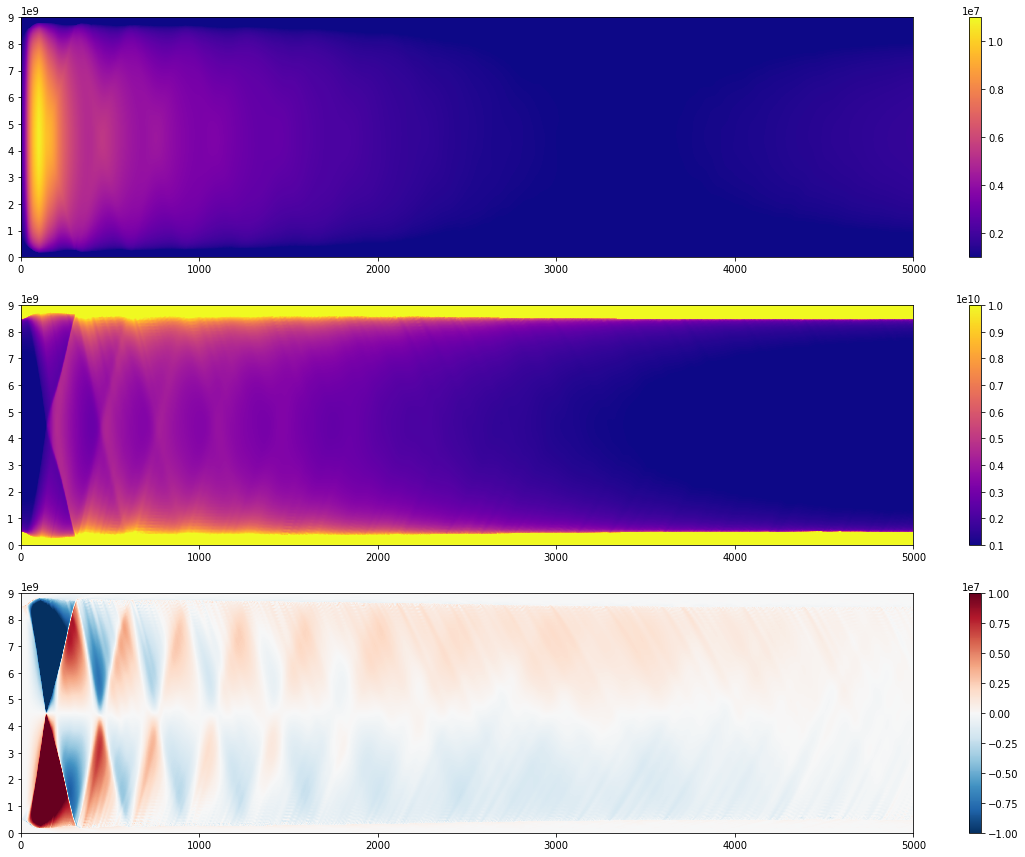

In [15]:
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.pcolormesh(grid_uniform_s,grid_uniform_t,Te_uniform,norm=matplotlib.colors.Normalize(vmin=1e6,vmax=1.1e7),cmap='plasma')
plt.colorbar()
#plt.xlim(0,1000)
plt.subplot(312)
plt.pcolormesh(grid_uniform_s,grid_uniform_t,n_uniform,norm=matplotlib.colors.Normalize(vmin=1e9,vmax=1e10),cmap='plasma')
plt.colorbar()
#plt.xlim(0,1000)
plt.subplot(313)
plt.pcolormesh(grid_uniform_s,grid_uniform_t,v_uniform,norm=matplotlib.colors.Normalize(vmin=-1e7,vmax=1e7),cmap='RdBu_r')
plt.colorbar()
#plt.xlim(0,1000)

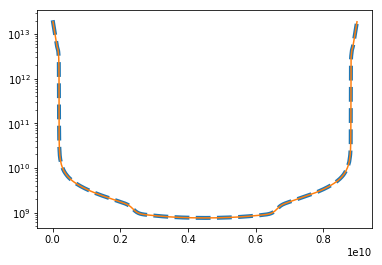

In [16]:
plt.plot(uniform_s,n_uniform[:,100],'--',lw=4,)
plt.plot(s[100].coordinate, s[100].electron_density)
plt.yscale('log')